<a href="https://colab.research.google.com/github/noviceswing/DEEPLEARING-pytorch/blob/main/Copy_of_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 基于注意力机制的机器翻译
# 导入需要的库
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.model_selection import train_test_split
import unicodedata
import re
import os
import io
import time

In [ ]:
# 用代码下载anki数据集
path_to_zip = tf.keras.utils.get_file('spa-eng.zip',
                          origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
                                    extract=True)
print(os.path.dirname(path_to_zip))
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

# 该数据集会存储在keras安装目录的datasets下


/root/.keras/datasets


In [ ]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))



<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 1. 去除重音符号
# 2. 清理句子
# 3. 返回这样格式的单词对：[ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# 将文本转换成数字序列
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

# 定义加载数据集
def load_dataset(path, num_examples=None):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# 尝试实验不同大小的数据集
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))


In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> no
17 ----> se
6077 ----> quedaran
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
28 ----> they
100 ----> won
12 ----> t
120 ----> stay
3 ----> .
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # 隐藏层的形状 == （批大小，隐藏层大小）
    # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
    # 这样做是为了执行加法以计算分数
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # 分数的形状 == （批大小，最大长度，1）
    # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
    # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
    attention_weights = tf.nn.softmax(score, axis=1)

    # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # 用于注意力
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
    x = self.embedding(x)

    # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 将合并后的向量传送到 GRU
    output, state = self.gru(x)

    # 输出的形状 == （批大小 * 1，隐藏层大小）
    output = tf.reshape(output, (-1, output.shape[2]))

    # 输出的形状 == （批大小，vocab）
    x = self.fc(output)

    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 4935)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [ ]:
# 开始训练模型
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.6024
Epoch 1 Batch 100 Loss 2.2012
Epoch 1 Batch 200 Loss 1.8533
Epoch 1 Batch 300 Loss 1.7553
Epoch 1 Loss 2.0608
Time taken for 1 epoch 48.127368688583374 sec

Epoch 2 Batch 0 Loss 1.6409
Epoch 2 Batch 100 Loss 1.6197
Epoch 2 Batch 200 Loss 1.4598
Epoch 2 Batch 300 Loss 1.3293
Epoch 2 Loss 1.4501
Time taken for 1 epoch 29.37078833580017 sec

Epoch 3 Batch 0 Loss 1.1196
Epoch 3 Batch 100 Loss 1.0889
Epoch 3 Batch 200 Loss 1.1044
Epoch 3 Batch 300 Loss 1.0188
Epoch 3 Loss 1.0599
Time taken for 1 epoch 28.69797706604004 sec

Epoch 4 Batch 0 Loss 0.8160
Epoch 4 Batch 100 Loss 0.7569
Epoch 4 Batch 200 Loss 0.5921
Epoch 4 Batch 300 Loss 0.7222
Epoch 4 Loss 0.7468
Time taken for 1 epoch 28.77109408378601 sec

Epoch 5 Batch 0 Loss 0.5514
Epoch 5 Batch 100 Loss 0.5383
Epoch 5 Batch 200 Loss 0.4907
Epoch 5 Batch 300 Loss 0.5630
Epoch 5 Loss 0.5264
Time taken for 1 epoch 28.49280858039856 sec



In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold . <end> 


<ipython-input-16-7196e6270c60>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-16-7196e6270c60>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


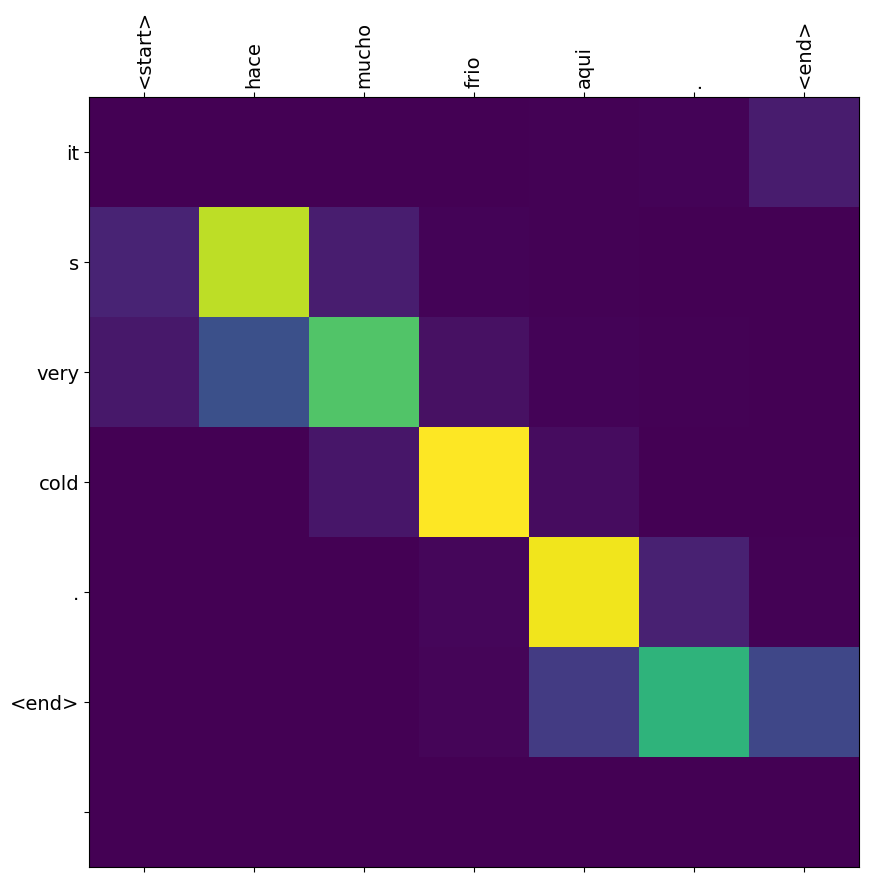

In [ ]:
# 加载保存的模型
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# 开始翻译
translate(u'hace mucho frio aqui.')